In [1]:
import os
import sys

# # if the working directory is not current one
# WORKING_DIR=''
# os.chdir(WORKING_DIR)
# print('Current working directory is',os.getcwd()) # to confirm the current working directory

Current working directory is C:\Users\yc_ya\iCloudDrive\3L68KQB4HG~com~readdle~CommonDocuments\ML_fin\nstransformer\Nonstationary_Transformers-main


In [2]:
import torch
import random
import numpy as np
from tools import *
from utils.tools import dotdict
from exp.exp_main import Exp_Main
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

import yfinance as yf

In [3]:
symbol= 'SPY' # stock symbol
start_date = "2010-01-01"
end_date = "2022-12-31"
data_filename = f"data/{symbol}_{start_date}_{end_date}.csv"

if not os.path.exists(data_filename):
    data = yf.download(symbol, start=start_date, end=end_date)

    # if wanna model the more stationary 
    # percentage change of the Close price
    data['diffs']=np.around(data['Close'].pct_change()*100,8)
    data['diffs'].fillna(0,inplace=True)
    
    data['date']=data.index
    data['date'].dt.strftime('%Y-%m-%d')
    data=data.reset_index(drop=True)
    data.to_csv(data_filename, index=False)
else:
    data = pd.read_csv(data_filename, parse_dates=True)

In [4]:
args = dotdict()
args.is_training = 1 # 1: True, 0: False
args.model_id = 'test'
args.model='Informer'  # model name, options: [ns_Transformer, Transformer]

# data loader
args.data = 'custom' # dataset type
args.root_path ='/'.join(data_filename.split('/')[:-1]) # root path of the data file
args.data_path =data_filename.split('/')[-1]  # data file
args.features='MS'   # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate'

args.target='Close'    # 'target feature in S or MS task'
args.auxil_features = ['Open','High','Low','Volume'] # other features to help predict the target feature
args.freq = 'd'     # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h'
args.checkpoints ='./checkpoints/'  # 'location of model checkpoints'

# forecasting task
args.seq_len = 20     # input sequence length
args.label_len = 10   # start token length
args.pred_len = 5    # prediction sequence lengthargs.

# model define
args.enc_in = len([args.target])+len(args.auxil_features)    # encoder input size
args.dec_in = args.enc_in #5    # decoder input size
args.c_out = 1     # output size
args.d_model = 256 # dimension of model
args.n_heads = 4   # num of heads
args.e_layers = 2  # num of encoder layers
args.d_layers = 1  # num of decoder layers
args.d_ff = 256   # dimension of fcn
args.moving_avg = 5  # window size of moving average
args.factor = 1    # attn factor
args.distil= True  # whether to use distilling in encoder, using this argument means not using distilling

args.dropout = 0.05    # dropout
args.embed = 'timeF'   # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu'  # 'activation'
args.output_attention = True    #  help='whether to output attention in encoder
args.do_predict = True # whether to predict unseen future data

# optimization
args.num_workers = 0     # data loader num workers
args.itr = 1              # experiments times
args.train_epochs = 100    # train epochs
args.batch_size = 128     # batch size of train input data
args.patience = 10         # early stopping patience
args.learning_rate = 0.0005  # optimizer learning rate
args.des = 'test'         # exp description
args.loss = 'mse'         # loss function
args.lradj = 'type1'      # adjust learning rate
args.use_amp = False       # use automatic mixed precision training

# GPU
args.use_gpu = True #False       # use gpu
args.gpu = 0              # gpu
args.use_multi_gpu = False
args.devices = '0,1,2,3'  # device ids of multile gpus
args.seed = 1234          # random seed

# de-stationary projector params
args.p_hidden_dims = [128, 128]  # hidden layer dimensions of projector (List)
args.p_hidden_layers = 2         # number of hidden layers in projector

In [5]:
seq_len = args.seq_len # 20
label_len = args.label_len # 10
batchsize = args.batch_size
num_train = int(len(data) * 0.7)
num_test = int(len(data) * 0.2)
num_vali = len(data) - num_train - num_test
border1s = [0, num_train - seq_len, len(data) - num_test - seq_len]
border2s = [num_train, num_train + num_vali, len(data)]

# for actual data in use:
#len(train)=num_train-seq_len-4
#len(val)=(num_train + num_vali)-(num_train - seq_len)-seq_len-4=num_vali-4
#len(test)=len(data)-(len(data) - num_test - seq_len)-seq_len-4=num_test-4

# nominal datasets:
train_data = data[(border1s[0]<=data.index)&(data.index<border2s[0])]
val_data = data[(border1s[1]<=data.index)&(data.index<border2s[1])]
test_data = data[(border1s[2]<=data.index)&(data.index<border2s[2])]

#  the index final 'test' dataset will plot : [(num_train + num_vali):(num_train + num_vali)+batchsize*((num_test-4)//batchsize)]
Ntest = batchsize*((num_test-4)//batchsize) # num of test data
test_plot_ind0 = (num_train + num_vali)
test_plot_ind1 = test_plot_ind0+Ntest
test_plot=test_data[(test_data.index>=test_plot_ind0)&(test_data.index<test_plot_ind1)]


In [6]:
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

fix_seed = args.seed
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

if args.use_gpu:
    if args.use_multi_gpu:
        args.devices = args.devices.replace(' ', '')
        device_ids = args.devices.split(',')
        args.device_ids = [int(id_) for id_ in device_ids]
        args.gpu = args.device_ids[0]
    else:
        torch.cuda.set_device(args.gpu)

print('Args in experiment:')
print(args)

Args in experiment:
{'is_training': 1, 'model_id': 'test', 'model': 'Informer', 'data': 'custom', 'root_path': 'data', 'data_path': 'SPY_2010-01-01_2022-12-31.csv', 'features': 'MS', 'target': 'Close', 'auxil_features': ['Open', 'High', 'Low', 'Volume'], 'freq': 'd', 'checkpoints': './checkpoints/', 'seq_len': 20, 'label_len': 10, 'pred_len': 5, 'enc_in': 5, 'dec_in': 5, 'c_out': 1, 'd_model': 256, 'n_heads': 4, 'e_layers': 2, 'd_layers': 1, 'd_ff': 256, 'moving_avg': 5, 'factor': 1, 'distil': True, 'dropout': 0.05, 'embed': 'timeF', 'activation': 'gelu', 'output_attention': True, 'do_predict': True, 'num_workers': 0, 'itr': 1, 'train_epochs': 100, 'batch_size': 128, 'patience': 10, 'learning_rate': 0.0005, 'des': 'test', 'loss': 'mse', 'lradj': 'type1', 'use_amp': False, 'use_gpu': True, 'gpu': 0, 'use_multi_gpu': False, 'devices': '0,1,2,3', 'seed': 1234, 'p_hidden_dims': [128, 128], 'p_hidden_layers': 2}


Use GPU: cuda:0
>>>>>>>start training : test_Informer_custom_ftMS_sl20_ll10_pl5_dm256_nh4_el2_dl1_df256_fc1_ebtimeF_dtTrue_test_0>>>>>>>>>>>>>>>>>>>>>>>>>>
border1s = [0, 2270, 2598]
border2s = [2290, 2618, 3272]
train 2266
border1s = [0, 2270, 2598]
border2s = [2290, 2618, 3272]
val 324
border1s = [0, 2270, 2598]
border2s = [2290, 2618, 3272]
test 650
Epoch: 1 cost time: 7.38740086555481
Epoch: 1, Steps: 17 | Train Loss: 0.4333694 Vali Loss: 0.5141479 Test Loss: 6.5665026
Validation loss decreased (inf --> 0.514148).  Saving model ...
Updating learning rate to 0.0005
Epoch: 2 cost time: 0.7959165573120117
Epoch: 2, Steps: 17 | Train Loss: 0.0633091 Vali Loss: 0.1153333 Test Loss: 4.1228971
Validation loss decreased (0.514148 --> 0.115333).  Saving model ...
Updating learning rate to 0.00025
Epoch: 3 cost time: 0.8296725749969482
Epoch: 3, Steps: 17 | Train Loss: 0.0335630 Vali Loss: 0.1825011 Test Loss: 4.4055452
EarlyStopping counter: 1 out of 10
Updating learning rate to 0.000125
Ep

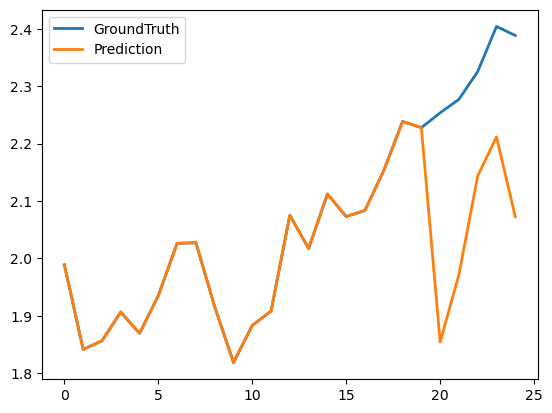

In [7]:
Exp = Exp_Main

if args.is_training:
    for ii in range(args.itr):
        # setting record of experiments
        setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
            args.model_id,
            args.model,
            args.data,
            args.features,
            args.seq_len,
            args.label_len,
            args.pred_len,
            args.d_model,
            args.n_heads,
            args.e_layers,
            args.d_layers,
            args.d_ff,
            args.factor,
            args.embed,
            args.distil,
            args.des, ii)

        exp = Exp(args)  # set experiments
        print('>>>>>>>start training : {}>>>>>>>>>>>>>>>>>>>>>>>>>>'.format(setting))
        exp.train(setting)

        print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
        exp.test(setting)

        if args.do_predict:
            print('>>>>>>>predicting : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
            exp.predict(setting, True)

        torch.cuda.empty_cache()
else:
    ii = 0
    setting = '{}_{}_{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_eb{}_dt{}_{}_{}'.format(
    args.model_id,
    args.model,
    args.data,
    args.features,
    args.seq_len,
    args.label_len,
    args.pred_len,
    args.d_model,
    args.n_heads,
    args.e_layers,
    args.d_layers,
    args.d_ff,
    args.factor,
    args.embed,
    args.distil,
    args.des, ii)

    exp = Exp(args)  # set experiments
    print('>>>>>>>testing : {}<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<'.format(setting))
    exp.test(setting, test=1)
    torch.cuda.empty_cache()

Use GPU: cuda:0
pred 1
(5,)


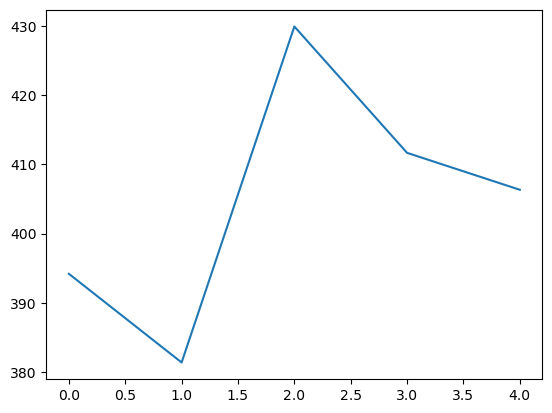

In [8]:
exp = Exp(args)
exp.predict(setting, load=True) # load=True: load the trained model weights

# prediction = np.load('./results/'+setting+'/real_prediction.npy')
prediction = np.load('./results/'+setting+'/real_scaled_back_prediction.npy')
print(prediction.shape)

plt.figure()
# plt.plot(prediction[0,:,-1])
plt.plot(prediction)
plt.show()

In [9]:
# When we finished exp.train(setting) and exp.test(setting), we will get a trained model and the results of test experiment
# The results of test experiment will be saved in ./results/{setting}/pred.npy (prediction of test dataset) and ./results/{setting}/true.npy (groundtruth of test dataset)

# preds = np.load('./results/'+setting+'/pred.npy')
# trues = np.load('./results/'+setting+'/true.npy')

preds = np.load('./results/'+setting+'/scaled_back_pred.npy')
trues = np.load('./results/'+setting+'/scaled_back_true.npy')

# [samples, pred_len, dimensions]
print(preds.shape, trues.shape)

# plt.figure()
# plt.plot(trues[10,:,-1], label='GroundTruth')
# plt.plot(preds[10,:,-1], label='Prediction')
# plt.legend()
# plt.show()

(640,) (640,)


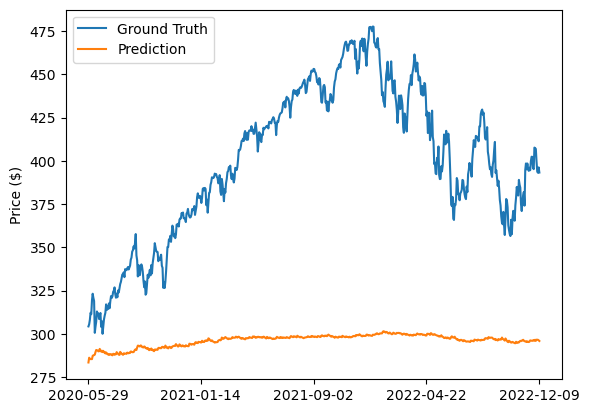

In [10]:
plt.figure()
# plt.plot(trues[:,0,-1].reshape(-1), label='GroundTruth')
# plt.plot(preds[:,0,-1].reshape(-1), label='Prediction')
plt.plot(trues, label='Ground Truth')
plt.plot(preds, label='Prediction')
plt.ylabel('Price ($)')
plt.xticks(ticks=np.linspace(0,Ntest-1,5,dtype=np.int32()),
           labels=[test_plot['date'].values[dd] for dd in np.linspace(0,Ntest-1,5,dtype=np.int32())])
plt.legend()
plt.show()

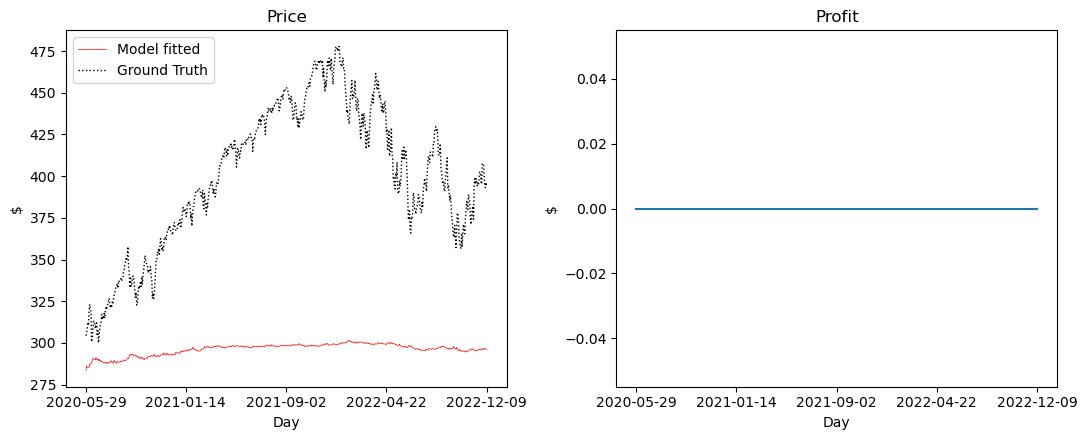

MSE: 12376.66
mean return per sell: nan
std of return per sell: nan


In [11]:
# simulate_price(trues[:,0,-1].reshape(-1),
#                preds[:,0,-1].reshape(-1)[1:],
#                buy_threshold=0.5)
simulate_price(data[:(test_plot_ind0+Ntest)]['Close'].values,
               preds,
               buy_threshold=0.5,
               date_labels=list(test_plot['date'].values))